# 📰 Notebook 6: Generador de Clickbaits con Seq2Seq

## Objetivos:
1. Preparar dataset: titular normal → titular clickbait
2. Usar modelo externo (LLM) para generar versiones clickbait
3. Entrenar modelo Seq2Seq encoder-decoder
4. Generar clickbaits automáticamente

## ¿Qué es un clickbait?
Un título sensacionalista diseñado para atraer clicks:
- Usa números y listas
- Crea curiosidad sin revelar todo
- Usa palabras emocionales
- Promete información impactante

In [1]:
# CELDA 1: Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Para Seq2Seq
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


In [2]:
# CELDA 2: Cargar datos
df = pd.read_csv(
    "noticias_unificadas.tsv",
    encoding="utf-8",
    sep="\t",
    dtype={"fecha": "string", "titulo": "string", "contenido": "string", "seccion": "string"},
    quoting=0,
    na_filter=False
)

print(f"Total de noticias: {len(df)}")
print(f"\nPrimeros titulares:")
for i in range(5):
    print(f"  {i+1}. {df['titulo'].iloc[i]}")

Total de noticias: 37746

Primeros titulares:
  1. Jueces rechazan intento de afectación a la independencia del Poder Judicial
  2. Liga 1: Lo gritan los “Churres” y todo el pueblo de Sullana
  3. Proponen sancionar con hasta 10 años de cárcel a quienes se cubran el rostro o lleven menores a protestas
  4. Este lunes inicia la semana de representación del Congreso
  5. Selección peruana evalúa reprogramación de partidos amistosos ante Rusia y Chile


In [3]:
# CELDA 3: Limpiar y preparar titulares
from utils.utils import clean_text

# Limpiar titulares
df['titulo_limpio'] = df['titulo'].fillna("").map(clean_text)

# Filtrar titulares válidos (longitud mínima y máxima)
df_filtered = df[
    (df['titulo_limpio'].str.len() >= 20) & 
    (df['titulo_limpio'].str.len() <= 150)
].copy()

print(f"Titulares válidos: {len(df_filtered)}")
print(f"\nEstadísticas de longitud:")
print(df_filtered['titulo_limpio'].str.len().describe())

Titulares válidos: 37678

Estadísticas de longitud:
count    37678.000000
mean        78.599581
std         17.585102
min         20.000000
25%         68.000000
50%         79.000000
75%         90.000000
max        148.000000
Name: titulo_limpio, dtype: float64


## 🤖 Generar Dataset de Clickbaits

Vamos a usar un LLM para transformar titulares normales en clickbait.

**Opciones:**
1. **Ollama** (local, gratis) - Recomendado
2. **OpenAI API** (de pago)
3. **Hugging Face** (modelos open source)

Usaremos **Ollama con Llama** por ser gratuito y funcionar localmente.

In [4]:
# CELDA 4: Verificar si Ollama está disponible
import subprocess
import json

def check_ollama():
    try:
        result = subprocess.run(['ollama', 'list'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ Ollama está instalado")
            print("\nModelos disponibles:")
            print(result.stdout)
            return True
        else:
            print("⚠️ Ollama no encontrado")
            return False
    except FileNotFoundError:
        print("❌ Ollama no está instalado")
        print("\nPara instalar:")
        print("  1. Visita: https://ollama.com")
        print("  2. Descarga e instala Ollama")
        print("  3. Ejecuta: ollama pull llama3.2:3b")
        return False

ollama_available = check_ollama()

✅ Ollama está instalado

Modelos disponibles:
NAME           ID              SIZE      MODIFIED      
llama3.2:3b    a80c4f17acd5    2.0 GB    4 minutes ago    



In [5]:
# CELDA 5: Función para generar clickbait con Ollama
import requests
import time

def generate_clickbait_ollama(titulo, model="llama3.2:3b", max_retries=3):
    """
    Genera versión clickbait de un titular usando Ollama
    """
    prompt = f"""Convierte este titular de noticia en un clickbait en español.
El clickbait debe:
- Ser sensacionalista y crear curiosidad
- Usar números cuando sea posible
- No revelar toda la información
- Usar palabras emocionales
- Ser corto (máximo 100 caracteres)

Titular original: {titulo}

Responde SOLO con el titular clickbait, sin explicaciones."""
    
    for attempt in range(max_retries):
        try:
            response = requests.post(
                'http://localhost:11434/api/generate',
                json={
                    'model': model,
                    'prompt': prompt,
                    'stream': False,
                    'options': {
                        'temperature': 0.8,
                        'top_p': 0.9
                    }
                },
                timeout=30
            )
            
            if response.status_code == 200:
                result = response.json()
                clickbait = result['response'].strip()
                # Limpiar posibles comillas o prefijos
                clickbait = clickbait.strip('"\'\'').strip()
                if len(clickbait) > 0 and len(clickbait) < 200:
                    return clickbait
        
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2)
            else:
                print(f"Error generando clickbait: {e}")
                return None
    
    return None

# Probar con un ejemplo
if ollama_available:
    ejemplo = df_filtered['titulo_limpio'].iloc[0]
    print(f"Titular original:\n  {ejemplo}")
    print("\nGenerando clickbait...")
    clickbait = generate_clickbait_ollama(ejemplo)
    print(f"\nClickbait generado:\n  {clickbait}")
else:
    print("⚠️ Ollama no disponible. Usando método alternativo...")

Titular original:
  jueces rechazan intento de afectacion a la independencia del poder judicial

Generando clickbait...

Clickbait generado:
  ¡10 Jueces rechazan trama para APUNTLAR AL PODER JUDICIAL! ¿Quién está detrás de esta conspiración?

Clickbait generado:
  ¡10 Jueces rechazan trama para APUNTLAR AL PODER JUDICIAL! ¿Quién está detrás de esta conspiración?


In [ ]:
# CELDA 6: Generar dataset de clickbaits
import os

# Intentar cargar dataset existente primero
if os.path.exists('dataset_clickbaits.csv'):
    print("📂 Dataset existente encontrado: 'dataset_clickbaits.csv'")
    print("¿Deseas usar el dataset existente? (Se saltará la generación)")
    print("\n⚠️ Si quieres regenerar, elimina el archivo 'dataset_clickbaits.csv' primero\n")
    
    # Cargar dataset existente
    df_sample = pd.read_csv('dataset_clickbaits.csv', encoding='utf-8')
    
    # Agregar columnas al dataframe original
    print(f"✅ Dataset cargado: {len(df_sample)} ejemplos")
else:
    # Generar nuevo dataset
    sample_size = 100  # Reducido para pruebas más rápidas
    
    df_sample = df_filtered.sample(n=min(sample_size, len(df_filtered)), random_state=42).copy()
    
    print(f"Generando clickbaits para {len(df_sample)} titulares...")
    print("Esto puede tardar varios minutos...\n")
    
    clickbaits = []
    failed = 0
    
    if ollama_available:
    for idx, row in df_sample.iterrows():
        if (len(clickbaits) + 1) % 10 == 0:
            print(f"Progreso: {len(clickbaits)}/{len(df_sample)}")
        
        clickbait = generate_clickbait_ollama(row['titulo_limpio'])
        
        if clickbait:
            clickbaits.append(clickbait)
        else:
            # Si falla, usar una transformación simple
            clickbait_simple = f"No creerás lo que pasó: {row['titulo_limpio'][:60]}..."
            clickbaits.append(clickbait_simple)
            failed += 1
        
        time.sleep(0.5)  # Evitar sobrecarga
    
    df_sample['clickbait'] = clickbaits
    print(f"\n✅ Generación completada")
    print(f"   Exitosos: {len(clickbaits) - failed}")
    print(f"   Fallidos: {failed}")
else:
    print("⚠️ Usando método alternativo sin Ollama...")
    # Método alternativo con patrones simples
    patrones = [
        "No vas a creer {}: descubre la verdad",
        "Esto es lo que NADIE te contó sobre {}",
        "5 razones por las que {} te dejará sin palabras",
        "La verdad detrás de {} que todos ocultan",
        "¿Qué pasó realmente con {}? La respuesta te sorprenderá",
        "Increíble: {} y lo que significa para ti"
    ]
    
    for idx, row in df_sample.iterrows():
        patron = np.random.choice(patrones)
        # Extraer fragmento del titular
        words = row['titulo_limpio'].split()[:5]
        fragment = ' '.join(words)
        clickbait = patron.format(fragment)
        clickbaits.append(clickbait)
    
    df_sample['clickbait'] = clickbaits
    print(f"✅ {len(clickbaits)} clickbaits generados con patrones")

Generando clickbaits para 500 titulares...
Esto puede tardar varios minutos...

Progreso: 9/500
Progreso: 9/500
Progreso: 19/500
Progreso: 19/500
Progreso: 29/500
Progreso: 29/500
Progreso: 39/500
Progreso: 39/500
Progreso: 49/500
Progreso: 49/500
Progreso: 59/500
Progreso: 59/500
Progreso: 69/500
Progreso: 69/500
Progreso: 79/500
Progreso: 79/500
Progreso: 89/500
Progreso: 89/500
Progreso: 99/500
Progreso: 99/500
Progreso: 109/500
Progreso: 109/500
Progreso: 119/500
Progreso: 119/500
Progreso: 129/500
Progreso: 129/500
Progreso: 139/500
Progreso: 139/500
Progreso: 149/500
Progreso: 149/500
Progreso: 159/500
Progreso: 159/500
Progreso: 169/500
Progreso: 169/500
Progreso: 179/500
Progreso: 179/500
Progreso: 189/500
Progreso: 189/500
Progreso: 199/500
Progreso: 199/500
Progreso: 209/500
Progreso: 209/500
Progreso: 219/500
Progreso: 219/500
Progreso: 229/500
Progreso: 229/500
Progreso: 239/500
Progreso: 239/500
Progreso: 249/500
Progreso: 249/500
Progreso: 259/500
Progreso: 259/500
Progre

In [7]:
# CELDA 7: Ver ejemplos del dataset generado
print("=" * 100)
print("EJEMPLOS DE TITULARES vs CLICKBAITS")
print("=" * 100)

for i in range(10):
    print(f"\n{i+1}.")
    print(f"   Original:  {df_sample.iloc[i]['titulo_limpio']}")
    print(f"   Clickbait: {df_sample.iloc[i]['clickbait']}")

EJEMPLOS DE TITULARES vs CLICKBAITS

1.
   Original:  inauguran cade ejecutivos 2024 en arequipa
   Clickbait: ¡Descubre quiénes son los 5 ejecutivos que cambiarán el destino de Arequipa en 2024!

2.
   Original:  denuncian que congresista maria acuna se niega a pagar impuestos por mas de s/3 millones a la sunat
   Clickbait: ¡Congresista de $3 MILLONES! ¿Paga sus impuestos o es un fraude?

3.
   Original:  ¡regresan los iconos del k-pop! v y rm de bts concluyen su servicio militar
   Clickbait: ¡RM y V regresan del frente! ¿Con qué sorpresa vuelve el rey del K-Pop?

4.
   Original:  ministerio publico inicia diligencias preliminares contra jose domingo perez
   Clickbait: ¡EXPOSADO! El Ministerio Público se lanzó a la persecución de Jose Díaz... y reveló un secreto que cambiará tu vida para siempre!

5.
   Original:  ley mape: ministro jorge montero no acudio a comision de energia y minas
   Clickbait: ¡El Ministro de Energía se Escabulla! ¡Montero evita la Comisión de Energía por más

In [8]:
# CELDA 8: Guardar dataset
df_sample[['titulo_limpio', 'clickbait']].to_csv(
    'dataset_clickbaits.csv',
    index=False,
    encoding='utf-8'
)

print("✅ Dataset guardado en 'dataset_clickbaits.csv'")
print(f"   Total de pares: {len(df_sample)}")

✅ Dataset guardado en 'dataset_clickbaits.csv'
   Total de pares: 500


In [ ]:
# CELDA 8.5: Verificar calidad del dataset
print("📊 VERIFICACIÓN DE CALIDAD DEL DATASET\n")

# Verificar que no hay valores nulos
print(f"Valores nulos en titulo_limpio: {df_sample['titulo_limpio'].isna().sum()}")
print(f"Valores nulos en clickbait: {df_sample['clickbait'].isna().sum()}")

# Verificar longitudes
print(f"\nLongitud promedio titular: {df_sample['titulo_limpio'].str.len().mean():.1f} caracteres")
print(f"Longitud promedio clickbait: {df_sample['clickbait'].str.len().mean():.1f} caracteres")

# Verificar vocabulario
all_words_input = ' '.join(df_sample['titulo_limpio']).split()
all_words_target = ' '.join(df_sample['clickbait']).split()
print(f"\nPalabras únicas en input: {len(set(all_words_input))}")
print(f"Palabras únicas en target: {len(set(all_words_target))}")

# Verificar si hay clickbaits demasiado cortos
short_clickbaits = df_sample[df_sample['clickbait'].str.len() < 20]
print(f"\nClickbaits muy cortos (< 20 chars): {len(short_clickbaits)}")

if len(short_clickbaits) > 0:
    print("⚠️ Advertencia: Algunos clickbaits son demasiado cortos")
    print("Ejemplos:")
    for i in range(min(3, len(short_clickbaits))):
        print(f"  '{short_clickbaits.iloc[i]['clickbait']}'")
    
    # Filtrar clickbaits muy cortos
    print("\n🔧 Filtrando clickbaits muy cortos...")
    df_sample = df_sample[df_sample['clickbait'].str.len() >= 20].copy()
    print(f"✅ Dataset filtrado: {len(df_sample)} ejemplos restantes")

### 💡 Nota importante sobre el dataset

Para que el modelo Seq2Seq funcione bien, necesita:
- **Mínimo 1000-2000 ejemplos** de entrenamiento
- **Clickbaits de buena calidad** (variados y bien formados)
- **Suficientes épocas de entrenamiento** (20-50 epochs)

Si el dataset generado es pequeño o de baja calidad, considera:
1. Generar más ejemplos con Ollama
2. Usar un dataset pre-existente de clickbaits
3. Aumentar el `sample_size` en la celda 6
4. Entrenar con más épocas

## 🧠 Preparar Datos para Seq2Seq

In [9]:
# CELDA 9: Preparar textos para Seq2Seq
# Agregar tokens especiales
df_sample['input_text'] = df_sample['titulo_limpio']
df_sample['target_text'] = '<start> ' + df_sample['clickbait'] + ' <end>'

print("Ejemplos con tokens especiales:")
print(f"\nInput:  {df_sample['input_text'].iloc[0]}")
print(f"Target: {df_sample['target_text'].iloc[0]}")

Ejemplos con tokens especiales:

Input:  inauguran cade ejecutivos 2024 en arequipa
Target: <start> ¡Descubre quiénes son los 5 ejecutivos que cambiarán el destino de Arequipa en 2024! <end>


In [10]:
# CELDA 10: Split train/test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_sample, 
    test_size=0.1, 
    random_state=42
)

print(f"Train: {len(train_df)} ejemplos")
print(f"Test:  {len(test_df)} ejemplos")

Train: 450 ejemplos
Test:  50 ejemplos


In [11]:
# CELDA 11: Tokenización
# Tokenizer para input (titulares originales)
input_tokenizer = Tokenizer(filters='', lower=True)
input_tokenizer.fit_on_texts(train_df['input_text'])

# Tokenizer para target (clickbaits)
target_tokenizer = Tokenizer(filters='', lower=True)
target_tokenizer.fit_on_texts(train_df['target_text'])

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print(f"Input vocabulary size:  {input_vocab_size}")
print(f"Target vocabulary size: {target_vocab_size}")

Input vocabulary size:  2705
Target vocabulary size: 2641


In [12]:
# CELDA 12: Convertir a secuencias
# Secuencias de entrada
encoder_input_train = input_tokenizer.texts_to_sequences(train_df['input_text'])
encoder_input_test = input_tokenizer.texts_to_sequences(test_df['input_text'])

# Secuencias de salida
decoder_input_train = target_tokenizer.texts_to_sequences(train_df['target_text'])
decoder_input_test = target_tokenizer.texts_to_sequences(test_df['target_text'])

# Calcular longitudes máximas
max_encoder_len = max([len(seq) for seq in encoder_input_train])
max_decoder_len = max([len(seq) for seq in decoder_input_train])

print(f"Max encoder length: {max_encoder_len}")
print(f"Max decoder length: {max_decoder_len}")

Max encoder length: 24
Max decoder length: 34


In [13]:
# CELDA 13: Padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_encoder_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_encoder_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_decoder_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_decoder_len, padding='post')

# Crear decoder output (shifted by 1)
decoder_output_train = np.zeros_like(decoder_input_train)
decoder_output_train[:, :-1] = decoder_input_train[:, 1:]

decoder_output_test = np.zeros_like(decoder_input_test)
decoder_output_test[:, :-1] = decoder_input_test[:, 1:]

print("Shapes:")
print(f"  Encoder input: {encoder_input_train.shape}")
print(f"  Decoder input: {decoder_input_train.shape}")
print(f"  Decoder output: {decoder_output_train.shape}")

Shapes:
  Encoder input: (450, 24)
  Decoder input: (450, 34)
  Decoder output: (450, 34)


## 🏗️ Construir Modelo Seq2Seq

In [14]:
# CELDA 14: Definir arquitectura Seq2Seq
# Hiperparámetros
embedding_dim = 256
latent_dim = 512

print("Construyendo modelo Seq2Seq...")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Latent dim: {latent_dim}")

# Encoder
encoder_inputs = Input(shape=(max_encoder_len,), name='encoder_input')
encoder_embedding = Embedding(
    input_vocab_size, 
    embedding_dim, 
    mask_zero=True,
    name='encoder_embedding'
)(encoder_inputs)

encoder_lstm = LSTM(
    latent_dim, 
    return_state=True,
    name='encoder_lstm'
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_decoder_len,), name='decoder_input')
decoder_embedding = Embedding(
    target_vocab_size, 
    embedding_dim,
    mask_zero=True,
    name='decoder_embedding'
)(decoder_inputs)

decoder_lstm = LSTM(
    latent_dim, 
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)
decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding,
    initial_state=encoder_states
)

decoder_dense = Dense(
    target_vocab_size, 
    activation='softmax',
    name='decoder_dense'
)
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model(
    [encoder_inputs, decoder_inputs], 
    decoder_outputs
)

model.summary()

Construyendo modelo Seq2Seq...
  Embedding dim: 256
  Latent dim: 512


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 24, 256)   │    692,480 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 34, 256)   │    676,096 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ encoder_embeddin… │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 34, 512), │  1,574,912 │ decoder_embeddin… │
│                     │ (None, 512),      │            │ encoder_lstm[0][… │
│                     │ (None, 512)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 34, 2641)  │  1,354,833 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,873,233 (22.40 MB)

 Trainable params: 5,873,233 (22.40 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# CELDA 15: Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo compilado")

✅ Modelo compilado


In [16]:
# CELDA 16: Entrenar modelo
print("Entrenando modelo...")
print("Esto puede tardar varios minutos...\n")

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Entrenar
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=32,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Entrenamiento completado")

Entrenando modelo...
Esto puede tardar varios minutos...

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.0817 - loss: 7.3148 - val_accuracy: 0.0855 - val_loss: 6.5520 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.0817 - loss: 7.3148 - val_accuracy: 0.0855 - val_loss: 6.5520 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.0943 - loss: 6.2008 - val_accuracy: 0.1454 - val_loss: 6.6430 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.0943 - loss: 6.2008 - val_accuracy: 0.1454 - val_loss: 6.6430 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.1485 - loss: 5.8544 - val_accuracy: 0.1582 - val_loss: 6.6220 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.1485 - loss: 5.8544 - val_accuracy: 0.1582 - val_loss: 6.6220 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━

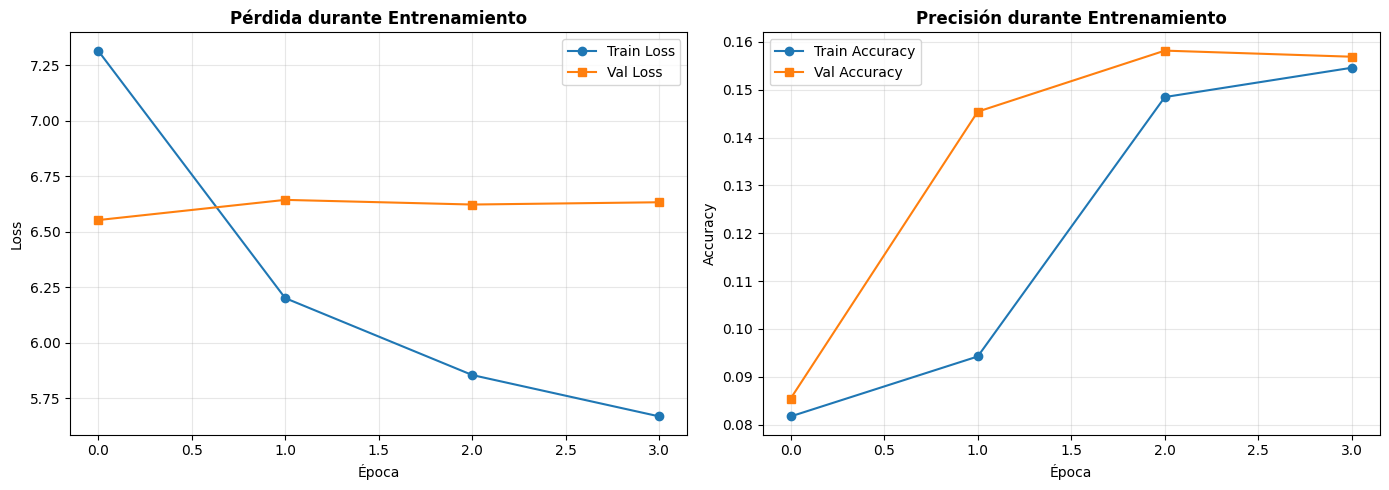

In [17]:
# CELDA 17: Visualizar entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss', marker='o')
ax1.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax1.set_title('Pérdida durante Entrenamiento', fontsize=12, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax2.set_title('Precisión durante Entrenamiento', fontsize=12, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 Modelos de Inferencia

In [22]:
# CELDA 18: Crear modelos de inferencia
# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model para inferencia
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Input para decoder (una palabra a la vez)
decoder_inputs_single = Input(shape=(1,), name='decoder_input_single')

# Obtener la capa de embedding del modelo original
decoder_embedding_layer = model.get_layer('decoder_embedding')
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_single)

# Obtener la capa LSTM del decoder
decoder_lstm_layer = model.get_layer('decoder_lstm')
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer(
    decoder_embedding_inf,
    initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Obtener la capa dense del decoder
decoder_dense_layer = model.get_layer('decoder_dense')
decoder_outputs_inf = decoder_dense_layer(decoder_outputs_inf)

# Modelo de inferencia del decoder
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

print("✅ Modelos de inferencia creados")

✅ Modelos de inferencia creados


In [ ]:
# CELDA 19: Función para generar clickbait
# Crear índice inverso para convertir índices a palabras
target_index_to_word = {index: word for word, index in target_tokenizer.word_index.items()}
target_index_to_word[0] = ''  # Para padding

def generate_clickbait(input_text, max_length=50):
    """
    Genera clickbait a partir de un titular
    """
    # Tokenizar input
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_len, padding='post')
    
    # Encode - obtener estados del encoder
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Generar secuencia vacía de longitud 1
    target_seq = np.zeros((1, 1))
    
    # Poblar primer caracter con token <start>
    start_token_index = target_tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token_index
    
    # Generar secuencia palabra por palabra
    stop_condition = False
    decoded_sentence = []
    
    while not stop_condition:
        # Predecir siguiente palabra
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value,
            verbose=0
        )
        
        # Obtener el índice del token con mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        # Convertir índice a palabra usando el diccionario inverso
        sampled_word = target_index_to_word.get(sampled_token_index, None)
        
        if sampled_word is None or sampled_word == '':
            break
        
        # Condiciones de parada
        if sampled_word == '<end>' or len(decoded_sentence) >= max_length:
            stop_condition = True
        elif sampled_word == '<start>':
            # Ignorar token <start> si aparece
            pass
        else:
            decoded_sentence.append(sampled_word)
        
        # Actualizar target_seq con el token generado
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # Actualizar estados del decoder
        states_value = [h, c]
    
    # Unir las palabras generadas
    result = ' '.join(decoded_sentence)
    
    # Si el resultado está vacío, devolver un mensaje
    if not result:
        return "[El modelo no pudo generar un clickbait]"
    
    return result

print("✅ Función de generación lista")
print(f"✅ Vocabulario target: {len(target_index_to_word)} palabras")

✅ Función de generación lista


### 🔍 Diagnóstico del Modelo

Si el modelo genera respuestas repetitivas o de baja calidad:
1. **Vocabulario limitado**: El modelo solo conoce las palabras del dataset de entrenamiento
2. **Overfitting**: El modelo memorizó patrones específicos en lugar de generalizar
3. **Dataset pequeño**: Con pocos ejemplos, el modelo no aprende bien

**Soluciones**:
- Regenerar con un dataset más grande (1000+ ejemplos)
- Entrenar más épocas con regularización
- Usar temperature sampling en lugar de argmax
- Verificar que los clickbaits del dataset sean de buena calidad

In [ ]:
# CELDA 19.5: Función mejorada con temperature sampling
def generate_clickbait_with_temperature(input_text, temperature=1.0, max_length=50):
    """
    Genera clickbait con temperature sampling para mayor variedad
    
    Args:
        input_text: Titular original
        temperature: Controla la aleatoriedad (0.5=conservador, 1.0=balanceado, 1.5=creativo)
        max_length: Longitud máxima del clickbait
    """
    # Tokenizar input
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_len, padding='post')
    
    # Encode - obtener estados del encoder
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Inicializar con token <start>
    target_seq = np.zeros((1, 1))
    start_token_index = target_tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token_index
    
    # Generar secuencia
    stop_condition = False
    decoded_sentence = []
    
    while not stop_condition:
        # Predecir siguiente palabra
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value,
            verbose=0
        )
        
        # Aplicar temperature
        predictions = output_tokens[0, -1, :]
        predictions = np.log(predictions + 1e-10) / temperature  # Evitar log(0)
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        
        # Muestrear según probabilidades (más variedad que argmax)
        sampled_token_index = np.random.choice(len(predictions), p=predictions)
        
        # Convertir índice a palabra
        sampled_word = target_index_to_word.get(sampled_token_index, None)
        
        if sampled_word is None or sampled_word == '':
            break
        
        # Condiciones de parada
        if sampled_word == '<end>' or len(decoded_sentence) >= max_length:
            stop_condition = True
        elif sampled_word != '<start>':
            decoded_sentence.append(sampled_word)
        
        # Actualizar secuencia y estados
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    
    result = ' '.join(decoded_sentence)
    return result if result else "[Sin resultado]"

print("✅ Función con temperature sampling lista")
print("   Usa temperature=0.5 para ser más conservador")
print("   Usa temperature=1.5 para ser más creativo")

## 🎪 Probar el Generador

In [24]:
# CELDA 20: Probar con ejemplos del test set
print("=" * 100)
print("GENERACIÓN DE CLICKBAITS - EJEMPLOS DEL TEST SET")
print("=" * 100)

for i in range(10):
    original = test_df['titulo_limpio'].iloc[i]
    real_clickbait = test_df['clickbait'].iloc[i]
    generated = generate_clickbait(original)
    
    print(f"\n{i+1}.")
    print(f"   Original:         {original}")
    print(f"   Clickbait Real:   {real_clickbait}")
    print(f"   Clickbait Gen:    {generated}")

GENERACIÓN DE CLICKBAITS - EJEMPLOS DEL TEST SET

1.
   Original:         turquia: erdogan arremete contra revista por caricatura sobre mahoma
   Clickbait Real:   ¡ERDOGAN DESTRUYE! ¿Cuál es la ofensa que sacudió a 1 millón de turcos?
   Clickbait Gen:    ¡descubre de

2.
   Original:         amargo adios: luka modric se despidio del real madrid con goleada en contra
   Clickbait Real:   Luka Modrić se despide ¡con una golazada de 5 goles ante su propio equipo!
   Clickbait Gen:    ¡descubre de de

1.
   Original:         turquia: erdogan arremete contra revista por caricatura sobre mahoma
   Clickbait Real:   ¡ERDOGAN DESTRUYE! ¿Cuál es la ofensa que sacudió a 1 millón de turcos?
   Clickbait Gen:    ¡descubre de

2.
   Original:         amargo adios: luka modric se despidio del real madrid con goleada en contra
   Clickbait Real:   Luka Modrić se despide ¡con una golazada de 5 goles ante su propio equipo!
   Clickbait Gen:    ¡descubre de de

3.
   Original:         arequipa: joven 

In [25]:
# CELDA 21: Probar con titulares personalizados
titulares_prueba = [
    "El presidente anuncia nuevas medidas económicas",
    "Perú clasifica al mundial de fútbol",
    "Descubren nueva especie de animal en la Amazonía",
    "Aumenta el precio del dólar en el mercado",
    "Científicos encuentran cura para enfermedad rara"
]

print("=" * 100)
print("GENERACIÓN DE CLICKBAITS - TITULARES PERSONALIZADOS")
print("=" * 100)

for i, titular in enumerate(titulares_prueba, 1):
    clickbait = generate_clickbait(titular)
    print(f"\n{i}.")
    print(f"   Original:  {titular}")
    print(f"   Clickbait: {clickbait}")

GENERACIÓN DE CLICKBAITS - TITULARES PERSONALIZADOS

1.
   Original:  El presidente anuncia nuevas medidas económicas
   Clickbait: ¡descubre de

2.
   Original:  Perú clasifica al mundial de fútbol
   Clickbait: ¡descubre de

3.
   Original:  Descubren nueva especie de animal en la Amazonía
   Clickbait: ¡descubre de de

2.
   Original:  Perú clasifica al mundial de fútbol
   Clickbait: ¡descubre de

3.
   Original:  Descubren nueva especie de animal en la Amazonía
   Clickbait: ¡descubre de de

4.
   Original:  Aumenta el precio del dólar en el mercado
   Clickbait: ¡descubre de de

5.
   Original:  Científicos encuentran cura para enfermedad rara
   Clickbait: de

4.
   Original:  Aumenta el precio del dólar en el mercado
   Clickbait: ¡descubre de de

5.
   Original:  Científicos encuentran cura para enfermedad rara
   Clickbait: de


In [26]:
# CELDA 22: Función interactiva
def generar_clickbait_interactivo():
    """
    Función interactiva para generar clickbaits
    """
    print("\n" + "=" * 80)
    print("🎪 GENERADOR INTERACTIVO DE CLICKBAITS")
    print("=" * 80)
    print("Escribe 'salir' para terminar\n")
    
    while True:
        titular = input("\n📰 Ingresa un titular: ").strip()
        
        if titular.lower() == 'salir':
            print("\n👋 ¡Hasta luego!")
            break
        
        if not titular:
            continue
        
        clickbait = generate_clickbait(titular)
        print(f"\n🎯 Clickbait generado: {clickbait}")

# Descomentar para usar:
# generar_clickbait_interactivo()

## 📊 Evaluación y Métricas

In [ ]:
# CELDA 23: Evaluar en test set
print("Evaluando modelo en test set...")

test_loss, test_acc = model.evaluate(
    [encoder_input_test, decoder_input_test],
    decoder_output_test,
    verbose=0
)

print(f"\n📊 Resultados en Test Set:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f}")

In [ ]:
# CELDA 24: Análisis de longitudes generadas
generated_clickbaits = []
for i in range(min(50, len(test_df))):
    original = test_df['titulo_limpio'].iloc[i]
    generated = generate_clickbait(original)
    generated_clickbaits.append(generated)

# Estadísticas
lengths_original = [len(t.split()) for t in test_df['titulo_limpio'].iloc[:50]]
lengths_real = [len(t.split()) for t in test_df['clickbait'].iloc[:50]]
lengths_generated = [len(t.split()) for t in generated_clickbaits]

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(lengths_original, alpha=0.5, label='Original', bins=15, color='blue')
ax.hist(lengths_real, alpha=0.5, label='Clickbait Real', bins=15, color='green')
ax.hist(lengths_generated, alpha=0.5, label='Clickbait Generado', bins=15, color='red')

ax.set_xlabel('Longitud (palabras)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de Longitudes de Titulares', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de longitud (palabras):")
print(f"  Original:  media={np.mean(lengths_original):.1f}, std={np.std(lengths_original):.1f}")
print(f"  Real:      media={np.mean(lengths_real):.1f}, std={np.std(lengths_real):.1f}")
print(f"  Generado:  media={np.mean(lengths_generated):.1f}, std={np.std(lengths_generated):.1f}")

In [ ]:
# CELDA 25: Guardar modelo
model.save('seq2seq_clickbait_generator.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

# Guardar tokenizers
import pickle

with open('input_tokenizer.pkl', 'wb') as f:
    pickle.dump(input_tokenizer, f)

with open('target_tokenizer.pkl', 'wb') as f:
    pickle.dump(target_tokenizer, f)

print("✅ Modelos y tokenizers guardados:")
print("   - seq2seq_clickbait_generator.h5")
print("   - encoder_model.h5")
print("   - decoder_model.h5")
print("   - input_tokenizer.pkl")
print("   - target_tokenizer.pkl")

In [ ]:
# CELDA 26: Resumen final
print("=" * 100)
print("📝 RESUMEN DEL GENERADOR DE CLICKBAITS")
print("=" * 100)

print(f"""
✅ **Dataset**:
   - Total de pares: {len(df_sample)}
   - Train: {len(train_df)} ejemplos
   - Test: {len(test_df)} ejemplos

✅ **Modelo Seq2Seq**:
   - Arquitectura: Encoder-Decoder LSTM
   - Embedding dim: {embedding_dim}
   - Latent dim: {latent_dim}
   - Input vocab: {input_vocab_size} palabras
   - Target vocab: {target_vocab_size} palabras

✅ **Resultados**:
   - Test Loss: {test_loss:.4f}
   - Test Accuracy: {test_acc:.4f}

💡 **Uso del modelo**:
   1. Cargar modelos guardados
   2. Usar generate_clickbait(titular)
   3. Generar clickbaits para nuevos titulares

🎯 **Ejemplos de uso**:
   - Titulares de noticias → Clickbaits automáticos
   - Análisis de sensacionalismo
   - Generación de contenido para redes sociales

⚠️ **Consideraciones éticas**:
   - Usar responsablemente
   - No desinformar
   - Mantener veracidad del contenido
""")